# Project: Identify Customer Segments

In this capstone project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for Arvato Financial Services in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by Bertelsmann Arvato Analytics and AZ Direct's Audience targeting database system, and represents a real-life data science task.

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, I will load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so I'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Check the structure of the data after it's loaded
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head(7)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help make cleaning decisions during this stage of the project. First of all, I will assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value.

In [6]:
pd.DataFrame(azdias.isnull().sum())

,0
AGER_TYP,0
ALTERSKATEGORIE_GROB,0
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0
FINANZ_UNAUFFAELLIGER,0
FINANZ_HAUSBAUER,0


In [7]:
# Identify missing or unknown data values and convert them to NaNs.

azdias.isnull().sum().sum() # Total missing values initially

4896838

In [8]:
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [9]:
print('Total number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))

Total number of missing values after conversion is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. 

In [10]:
# Perform an assessment of how much missing data there is in each column of the dataset.
percentage_missing_per_column =(azdias.isnull().sum()/len(azdias))*100

(array([31.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  7.,  0., 14.,  5.,  5.,
         7.,  6.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.99757636,  1.99515272,  2.99272908,  3.99030543,
         4.98788179,  5.98545815,  6.98303451,  7.98061087,  8.97818723,
         9.97576359, 10.97333995, 11.9709163 , 12.96849266, 13.96606902,
        14.96364538, 15.96122174, 16.9587981 , 17.95637446, 18.95395082,
        19.95152717, 20.94910353, 21.94667989, 22.94425625, 23.94183261,
        24.93940897, 25.93698533, 26.93456169, 27.93213804, 28.929714

Text(0,0.5,'Number of Columns')

Text(0.5,0,'Percentage of Missing Values')

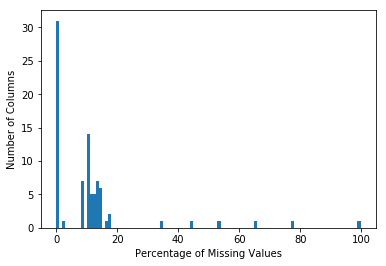

In [11]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percentage_missing_per_column, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.show()


In [12]:
# Remove the outlier columns from the dataset. 
percentage_missing_per_column_20 = percentage_missing_per_column[percentage_missing_per_column>20]

In [13]:
drop_coloumns = percentage_missing_per_column_20.index.tolist()
print('These columns have more than 20 percent missing data, and will be dropped:{}'.format(drop_coloumns))

These columns have more than 20 percent missing data, and will be dropped:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [14]:
azdias = azdias.drop(drop_coloumns, axis=1)

In [15]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

The amount of missing data in the majority of columns is below 20%. However, there are certain columns that contain close to 100% (No data inside the column) missing values. I chose to remove all columns with upwards of 20% missing data because of two reasons:

1. There are very few columns that have greater than 20% missing data. The majority of columns are clustered with the 0-20% missing values range.

2. In further steps, I might want to remove rows with missing values and if the columns with greater than 20% missing values are not removed before, I might end up losing out on a lot of important data as more than 20% rows will end up being removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, I  see some groups of points that have a very different numbers of missing values. I shall Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I will see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.


Depending on what I will observe in my comparison, this will have implications on how I approach my conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then I could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then I should make a note on those data as special. I'll revisit these data later on. 

(array([6.23209e+05, 0.00000e+00, 1.57380e+04, 0.00000e+00, 2.79260e+04,
        0.00000e+00, 1.76290e+04, 0.00000e+00, 1.26070e+04, 0.00000e+00,
        2.25150e+04, 0.00000e+00, 1.37710e+04, 0.00000e+00, 1.37140e+04,
        0.00000e+00, 2.45920e+04, 0.00000e+00, 3.04200e+03, 0.00000e+00,
        5.41000e+03, 0.00000e+00, 1.12700e+03, 0.00000e+00, 7.66000e+02,
        0.00000e+00, 3.25500e+03, 0.00000e+00, 2.24300e+03, 0.00000e+00,
        4.74300e+03, 0.00000e+00, 2.50500e+03, 0.00000e+00, 6.77000e+02,
        0.00000e+00, 4.28000e+02, 0.00000e+00, 1.18000e+03, 0.00000e+00,
        3.49000e+02, 0.00000e+00, 1.50000e+02, 0.00000e+00, 1.29000e+02,
        0.00000e+00, 1.32000e+02, 0.00000e+00, 6.90000e+01, 0.00000e+00,
        0.00000e+00, 5.50000e+01, 0.00000e+00, 5.90000e+01, 0.00000e+00,
        2.40000e+01, 0.00000e+00, 5.00000e+00, 0.00000e+00, 1.20000e+01,
        0.00000e+00, 6.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00,
        2.06000e+02, 0.00000e+00, 2.98500e+03, 0.00

Text(0,0.5,'Number of Rows')

Text(0.5,0,'Number of Missing Values')

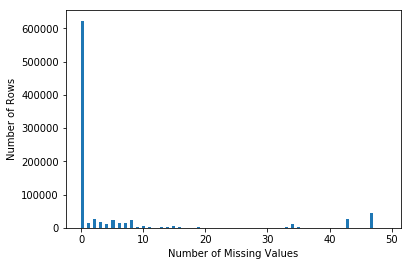

In [16]:
# How much data is missing in each row of the dataset?
missing_values_per_row = azdias.isnull().sum(axis=1)
plt.hist(missing_values_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()


In [17]:
#  code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_less_missing = azdias[missing_values_per_row <= 20]
azdias_more_missing = azdias[missing_values_per_row > 20]

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

zero_missing_coloumns = percentage_missing_per_column[percentage_missing_per_column==0].index.tolist()
compare_columns = zero_missing_coloumns[:6]

Text(0.5,1,'20 or less than 20 missing values')

Text(0.5,1,'More than 20 missing values')

Text(0.5,1,'20 or less than 20 missing values')

Text(0.5,1,'More than 20 missing values')

Text(0.5,1,'20 or less than 20 missing values')

Text(0.5,1,'More than 20 missing values')

Text(0.5,1,'20 or less than 20 missing values')

Text(0.5,1,'More than 20 missing values')

Text(0.5,1,'20 or less than 20 missing values')

Text(0.5,1,'More than 20 missing values')

Text(0.5,1,'20 or less than 20 missing values')

Text(0.5,1,'More than 20 missing values')

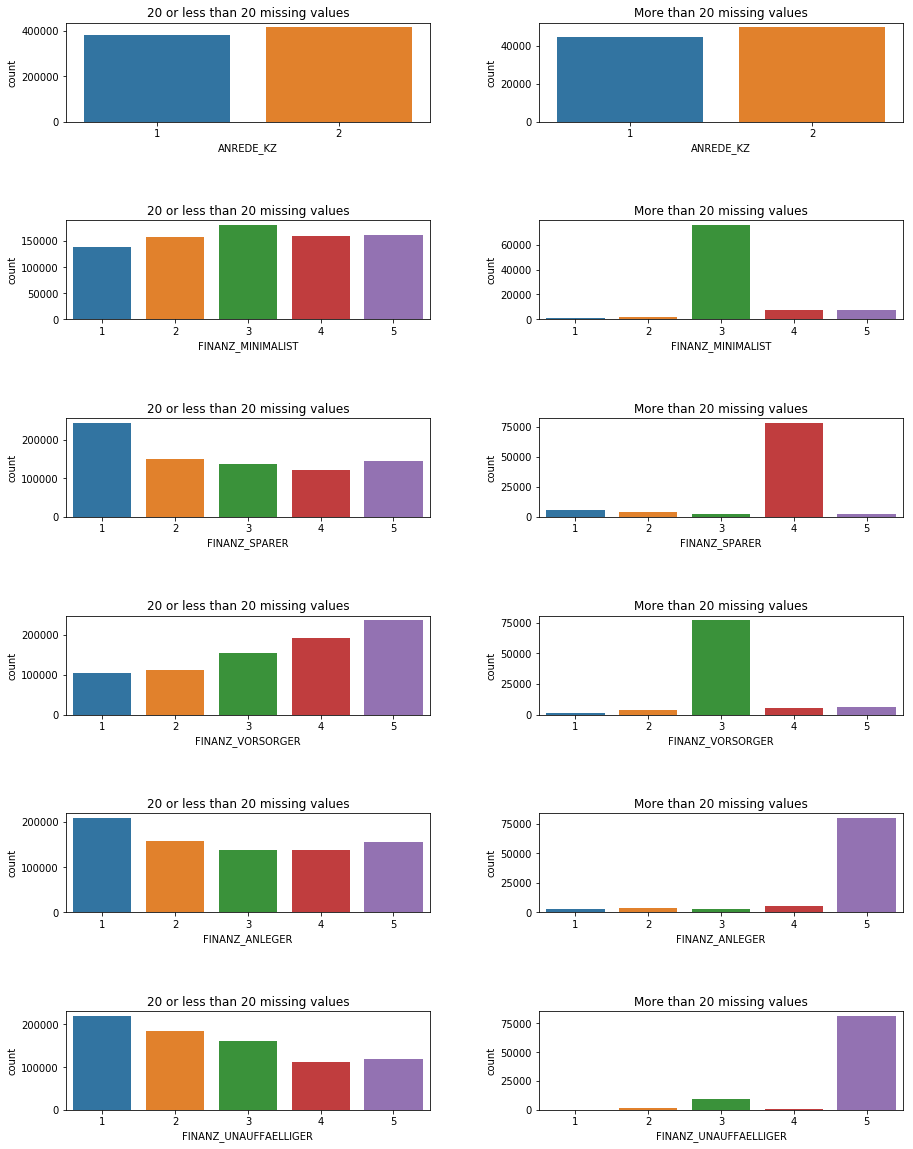

In [19]:
figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_columns)):
    sns.countplot(azdias_less_missing[compare_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('20 or less than 20 missing values')
    sns.countplot(azdias_more_missing[compare_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('More than 20 missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of different values contained within a column for the 2 datasets appears to be simlar for the gender column (ANREDE_KZ) and contrastingly different for other financial topology columns

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which I can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

In [20]:
# How many features are there of each data type?
azdias_less_missing.dtypes.value_counts()



float64    51
int64      24
object      4
dtype: int64

In [21]:
features = list(azdias_less_missing.columns)

In [22]:
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]

In [23]:
data_type_count = feat_info_clean['type'].value_counts()
data_type_count

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info_clean[feat_info_clean['type']=='categorical']['attribute']
categorical_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [25]:
binary_categorical_feature = []
multi_level_categorical_feature=[]
for feature in categorical_features:
    if (len(azdias_less_missing[feature].unique())==2):
        binary_categorical_feature.append(feature)
    elif (len(azdias_less_missing[feature].unique())>2):
        multi_level_categorical_feature.append(feature)

In [26]:
binary_categorical_feature # Binary feature list
multi_level_categorical_feature # multi-level feature list

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [27]:
for feature in binary_categorical_feature:
    print(feature,azdias_less_missing[feature].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [1. 0.]
OST_WEST_KZ ['W' 'O']


In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
new_encoding_values = {'W': 0, 'O': 1}
azdias_clean = azdias_less_missing.replace({'OST_WEST_KZ':new_encoding_values})

In [29]:
for feature in multi_level_categorical_feature:
    azdias_clean=azdias_clean.drop(feature, axis=1)    #This will drop the multi-level categorical feature columns

#### Discussion 1.2.1: Re-Encode Categorical Features

+ Out of all the binary categorical columns, only the **OST_WEST_KZ** column that tells whether the location of the house was in east or west germany had non numerical categories i.e 'W' depicting west and 'O' depicting east. These were re-encoded as 0 and 1 respectively. 

+ We do not need to interfere with other binary categorical variables as they are all numerically encoded in the first place and a (2,1) pair would not affect analysis as we would be standardizing or normalizing before moving ahead with any machine learning technique.

+ The multi-valued categorical variable feature columns were dropped as one-hot encoding them using the pd.get_dummies() method would result in an extremely high dimensional dataset. Note: To further improve the analysis, if we want to create dummy variables for any multi-valued feature column, then that column should be the **FINANZTYP** column as it does contain some important information that can be useful while clustering.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

In [32]:
decade_replace_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_replace_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [33]:
azdias_clean['DECADE'].replace(decade_replace_dict, inplace=True)
azdias_clean['MOVEMENT'].replace(movement_replace_dict, inplace=True)

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']

In [35]:
wealth_replace_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_replace_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [36]:
azdias_clean['WEALTH'].replace(wealth_replace_dict, inplace=True)
azdias_clean['LIFE_STAGE'].replace(life_stage_replace_dict, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

+ I decided to keep both the **CAMEO_INTL_2015** and **PRAEGENDE_JUGENDJAHRE** mixed type feature columns
+ These columns contained multiple features within them
+ The **PRAEGENDE_JUGENDJAHRE** column contained information along three axes but I chose just 2 to be important as the nation axis (east or west) was already covered by some other feature column
+ I created **WEALTH** and **LIFE_STAGE** column and copied values from the **CAMEO_INTL_2015** column, encoded values from wealth_replace_dict and life_stage_replace_dict dictionary
+ Similar step was also taken for the **PRAEGENDE_JUGENDJAHRE** column

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, I need to make sure that your data frame now only has the columns that I want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [37]:
mixed_features_column = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
for feature in mixed_features_column:
    azdias_clean.drop(feature, axis=1, inplace=True) 
    
#This will drop the above two mixed feature columns that we do not need now as we have replaced them with re-engineered 
#columns
    


In [38]:
azdias_clean.head() # One final check of all the columns

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I'll need to perform the same cleaning steps on the customer demographics data. In this substep, I will develop the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_clean = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    
    # remove selected columns and rows, drop columns with more than 20% missing values
    columns_miss_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(columns_miss_20, axis=1)
    # drop rows with more than 3 missing values
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 20]

    
    # select, re-encode, and engineer column values, re-encode binary feature
    new_values = {'W': 0, 'O': 1}
    df_clean = df_clean.replace({'OST_WEST_KZ':new_values})
    
    # drop multi-level categorical feature columns
    cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    multi_level_feature=[]
    for feature in cat_features:
        if (len(azdias_less_missing[feature].unique())>2):
            multi_level_feature.append(feature)
    for feature in multi_level_feature:
        df_clean=df_clean.drop(feature, axis=1)
        
        # engineer mixed features
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    for feature in mixed_features:
        df_clean.drop(feature, axis=1, inplace=True)

    
    # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, I'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help me navigate to all of the classes and functions that I'll need. In this substep, I'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to  data, make sure that I've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. I might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. 
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, I can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time

In [40]:
from sklearn.impute import SimpleImputer
missing_values_filler = SimpleImputer(strategy='most_frequent')

In [41]:
azdias_clean_imputed = pd.DataFrame(missing_values_filler.fit_transform(azdias_clean))

In [42]:
azdias_clean_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


Upon imputation, we lost the column names and indexes. I will put back the column names and indez values to the imputed dataframe from the cleaned dataframe

In [43]:
azdias_clean_imputed.columns = azdias_clean.columns
azdias_clean_imputed.index = azdias_clean.index

In [44]:
azdias_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [45]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean_imputed)

In [46]:
azdias_scaled = pd.DataFrame(azdias_scaled)

In [47]:
azdias_scaled.columns = azdias_clean_imputed.columns
azdias_scaled.index = azdias_clean_imputed.index

In [48]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.010368,...,0.441766,1.455006,0.573846,-0.171603,-0.127145,0.684744,1.098531,0.530567,1.175734,-1.249157
2,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.010368,...,-0.935489,0.419154,0.573846,-0.171603,-0.127145,-0.789154,1.098531,-1.884775,-0.869674,0.766845
3,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.311674,...,-0.935489,-0.616697,0.573846,-1.173369,-0.997689,-0.052205,-0.267356,0.530567,-1.551476,-0.577156
4,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.010368,...,0.441766,-0.616697,-0.337337,0.830164,0.308127,1.421694,-0.267356,0.530567,0.493932,0.094845
5,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.010368,...,0.441766,1.455006,1.485029,-1.173369,-0.997689,-0.052205,-1.633243,0.530567,1.175734,0.766845


### Discussion 2.1: Apply Feature Scaling

+ All the remaining missing values were replaced with the most frequent values present in that respective column 
+ This was done using the Imputer method from sklearn
+ The dataframe matrix was then standardized (scaled) using the standard scaler method from sklearn

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, I am now ready to apply dimensionality reduction techniques.

- Using sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, i should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what i find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once i've made a choice for the number of components to keep, make sure to re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 63 artists>

Text(0.5,1,'Variance explained by each component')

Text(0.5,0,'Principal component')

Text(0,0.5,'Ratio of variance explained')

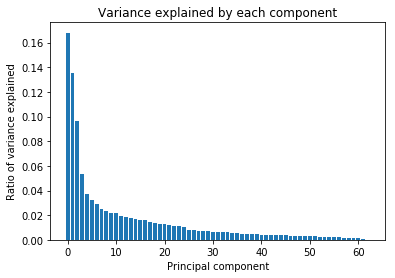

In [50]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


Text(0.5,1,'Cumulative Variance Explained')

Text(0.5,0,'Number of Components')

Text(0,0.5,'Ratio of variance explained')

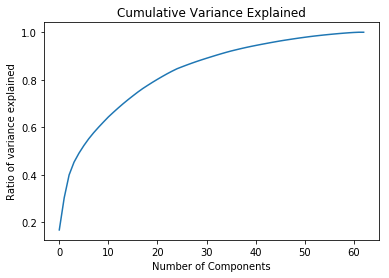

In [51]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()


In [52]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(n_components=30)
azdias_pca = pca_2.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

+ First 20 principal components account for roughly 75% of the variance
+ The first 30 principal explain roughly 90% of the variation in data
+ The first 40 principal components explain between 90 - 95% variance
+ It makes sense to keep the number of principal components at 30 as it explains a lot of variation (increasing the number of principal components any further makes no significant difference) and it reduces the dimensionality of the dataset by over 50%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
#  a function here or in a new cell that i can reuse in the
# other cells.
def pca_weights_calculator(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights


In [54]:
pca_weight_first_component = pca_weights_calculator(pca_2, 0)
print (pca_weight_first_component)

PLZ8_ANTG3               0.225113
PLZ8_ANTG4               0.216707
WEALTH                   0.204511
HH_EINKOMMEN_SCORE       0.202140
ORTSGR_KLS9              0.196389
EWDICHTE                 0.194206
FINANZ_HAUSBAUER         0.159226
FINANZ_SPARER            0.153800
KBA05_ANTG4              0.153789
PLZ8_ANTG2               0.153456
ARBEIT                   0.142393
KBA05_ANTG3              0.136674
ANZ_HAUSHALTE_AKTIV      0.135870
RELAT_AB                 0.134715
SEMIO_PFLICHT            0.121968
SEMIO_REL                0.119497
DECADE                   0.112947
MOVEMENT                 0.110250
SEMIO_RAT                0.100503
SEMIO_TRADV              0.094804
SEMIO_MAT                0.083795
FINANZ_UNAUFFAELLIGER    0.081817
SEMIO_FAM                0.081650
SEMIO_KULT               0.076372
FINANZ_ANLEGER           0.075766
REGIOTYP                 0.060357
OST_WEST_KZ              0.053795
SEMIO_SOZ                0.043543
PLZ8_HHZ                 0.042129
HEALTH_TYP    

In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_second_component = pca_weights_calculator(pca_2, 1)
print (pca_weight_second_component)

ALTERSKATEGORIE_GROB     0.256059
SEMIO_ERL                0.229831
FINANZ_VORSORGER         0.228709
SEMIO_LUST               0.179836
RETOURTYP_BK_S           0.161748
FINANZ_HAUSBAUER         0.122589
SEMIO_KRIT               0.117781
SEMIO_KAEM               0.116840
W_KEIT_KIND_HH           0.114899
PLZ8_ANTG3               0.099529
EWDICHTE                 0.098558
ORTSGR_KLS9              0.097340
PLZ8_ANTG4               0.097230
ANREDE_KZ                0.093649
WEALTH                   0.080225
KBA05_ANTG4              0.075926
SEMIO_DOM                0.074545
ARBEIT                   0.072484
RELAT_AB                 0.069845
PLZ8_ANTG2               0.068854
ANZ_HAUSHALTE_AKTIV      0.067085
HH_EINKOMMEN_SCORE       0.062834
FINANZ_MINIMALIST        0.058392
WOHNDAUER_2008           0.058138
KBA05_ANTG3              0.051234
ANZ_HH_TITEL             0.032219
OST_WEST_KZ              0.027990
MOVEMENT                 0.018985
PLZ8_HHZ                 0.015944
REGIOTYP      

In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_third_component = pca_weights_calculator(pca_2, 2)
print (pca_weight_third_component)


SEMIO_VERT               0.344671
SEMIO_SOZ                0.261865
SEMIO_FAM                0.248853
SEMIO_KULT               0.233800
FINANZ_MINIMALIST        0.154520
RETOURTYP_BK_S           0.109157
FINANZ_VORSORGER         0.101783
W_KEIT_KIND_HH           0.085207
ALTERSKATEGORIE_GROB     0.079814
SEMIO_REL                0.067751
SEMIO_LUST               0.064629
SEMIO_MAT                0.055680
ORTSGR_KLS9              0.050286
EWDICHTE                 0.049491
PLZ8_ANTG4               0.049148
PLZ8_ANTG3               0.048480
GREEN_AVANTGARDE         0.047077
ARBEIT                   0.037333
RELAT_AB                 0.034344
PLZ8_ANTG2               0.032707
WOHNDAUER_2008           0.032599
WEALTH                   0.030201
KBA05_ANTG4              0.029982
ANZ_HAUSHALTE_AKTIV      0.026809
OST_WEST_KZ              0.016315
ANZ_HH_TITEL             0.013931
KBA05_ANTG3              0.011848
ANZ_TITEL                0.009710
PLZ8_HHZ                 0.005566
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

Here are some interesting findings from our analysis of the first, second and third principal component:

1. The first principal component seems to be about the quantity of houses of certain number of members in that region and the wealth of the household as the strongest postive or negative feature weights are for the PLZ8 type columns and the WEALTH column

2. The second principal component possibly pertains to the type of individual that covers the person's age, personality typology and financial typology

3. The third principal component seems to be a combination of a person's gender and the person's complete personality type covering almost all personality typologies

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [57]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
def k_means_scorer(data, cluster_count):
    kmeans = KMeans(n_clusters = cluster_count)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score
    
    

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
#  Using matplotlib's plot function to visualize this relationship.
scores = []
k_values = [3,5,7,9,11,13,15,17]
for k in k_values:
    scores.append(k_means_scorer(azdias_pca,k))

Text(0.5,0,'K')

Text(0,0.5,'SSE')

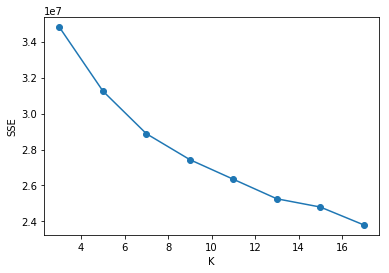

In [59]:
plt.plot(k_values, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=13)
clusterer_13 = kmeans.fit(azdias_pca)
azdias_pred = clusterer_13.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

It seems like the elbow exists at k equals 13 as the plot pretty much flattens from there on. This is why, I took the value of K as 13

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Taking care to not confuse this for re-fitting all of the models to the customer data. Instead, I'm going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';') 

In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)


In [63]:
# Imputing remaining NaNs
customers_imputed = pd.DataFrame(missing_values_filler.fit_transform(customers_clean))
customers_imputed.columns = customers_clean.columns
customers_imputed.index = customers_clean.index

In [64]:
# Standardizing / Scaling
customers_scaled = scaler.transform(customers_imputed)
customers_scaled = pd.DataFrame(customers_scaled, columns=list(customers_imputed))
# PCA 
customers_pca = pca_2.transform(customers_scaled)

In [65]:
# K-Means
customers_pred = clusterer_13.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If I think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then I should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Text(0.5,1,'Customer Clusters')

Text(0.5,1,'General Clusters')

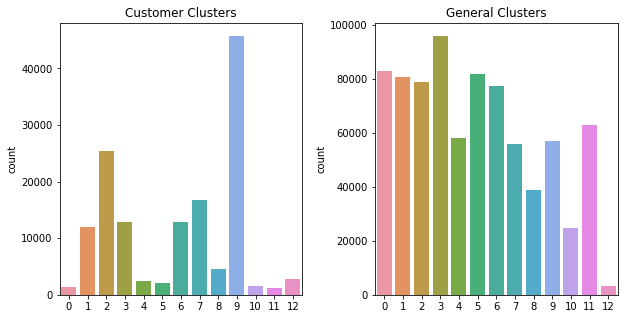

In [66]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')


In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_9 = scaler.inverse_transform(pca_2.inverse_transform(clusterer_13.cluster_centers_[9]))

In [68]:
overrepresented_c = pd.Series(data = centroid_9, index = customers_clean.columns)


In [69]:
overrepresented_c

ALTERSKATEGORIE_GROB        3.300068
ANREDE_KZ                   1.055336
FINANZ_MINIMALIST           4.824085
FINANZ_SPARER               1.638548
FINANZ_VORSORGER            4.179368
FINANZ_ANLEGER              1.521514
FINANZ_UNAUFFAELLIGER       2.161482
FINANZ_HAUSBAUER            1.912290
GREEN_AVANTGARDE            0.990209
HEALTH_TYP                  2.094073
RETOURTYP_BK_S              3.971303
SEMIO_SOZ                   4.873439
SEMIO_FAM                   4.800508
SEMIO_REL                   3.717127
SEMIO_MAT                   3.925980
SEMIO_VERT                  6.223388
SEMIO_LUST                  5.230835
SEMIO_ERL                   4.102440
SEMIO_KULT                  4.899265
SEMIO_RAT                   2.693712
SEMIO_KRIT                  3.090252
SEMIO_DOM                   3.341891
SEMIO_KAEM                  2.642899
SEMIO_PFLICHT               3.187623
SEMIO_TRADV                 3.124387
SOHO_KZ                     0.008678
ANZ_PERSONEN                2.212895
A

In [70]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_0 = scaler.inverse_transform(pca_2.inverse_transform(clusterer_13.cluster_centers_[0]))



In [71]:
underrepresented_c = pd.Series(data = centroid_0, index = customers_clean.columns)


In [72]:
underrepresented_c

ALTERSKATEGORIE_GROB        1.688108
ANREDE_KZ                   2.001457
FINANZ_MINIMALIST           1.190221
FINANZ_SPARER               4.284760
FINANZ_VORSORGER            2.204513
FINANZ_ANLEGER              4.141782
FINANZ_UNAUFFAELLIGER       3.703493
FINANZ_HAUSBAUER            4.158776
GREEN_AVANTGARDE            0.037623
HEALTH_TYP                  2.323623
RETOURTYP_BK_S              2.674357
SEMIO_SOZ                   3.222874
SEMIO_FAM                   3.939782
SEMIO_REL                   5.385353
SEMIO_MAT                   4.894083
SEMIO_VERT                  2.206601
SEMIO_LUST                  3.211765
SEMIO_ERL                   4.319418
SEMIO_KULT                  4.119723
SEMIO_RAT                   6.124328
SEMIO_KRIT                  5.498834
SEMIO_DOM                   6.143897
SEMIO_KAEM                  6.126334
SEMIO_PFLICHT               6.231007
SEMIO_TRADV                 5.516138
SOHO_KZ                     0.008049
ANZ_PERSONEN                1.464116
A

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Overrepresented

Cluster 9 is overrepresented in the customers data compared to the general population. This cluster has a certain distinct features. 
+ The coordinate of the centroid along the WEALTH axis indicates that people belonging to this cluster belong to prosperous households
+ The coordinate of the centroid along the LIFE_STAGE axis indicates that people belonging to this cluster are somewhere between being a family with school age children and being mature couples. Maybe family with college going children?
+ The coordinate of the centroid along the PLZ8_ANTG3 axis indicates that people belonging to this cluster live in neigbourhoods that have a low count of households with 6-10 people in it

#### Underrepresented

Cluster 0 is underrepresented (Highest difference) in the customers data compared to the general population. This cluster has a certain distinct features. 
+ The coordinate of the centroid along the WEALTH axis indicates that people belonging to this cluster belong to less affluent households
+ The coordinate of the centroid along the LIFE_STAGE axis indicates that people belonging to this cluster are young couple families with children
+ The coordinate of the centroid along the PLZ8_ANTG3 axis indicates that people belonging to this cluster live in neigbourhoods that have a moderate to high count of households with 6-10 people in it



#### Business Insight

The company should focus more on acquiring people as customers who are less affluent young couple families with children that live in neighbourhoods with high count of households with 6-10 people in it